In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import random
import gc
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.ensemble import RandomForestRegressor


In [2]:
snp=np.load('/home/panwei/fu000217/dl/LipA/7_apply/realdata/all_snp_matrix/test/test_snp_final.npy')
covariates=pd.read_csv('/home/panwei/fu000217/dl/LipA/7_apply/realdata/extract_covariates/test/covariates.csv')
snp = pd.DataFrame(snp)
covariates=covariates.drop(columns='ID')
X=pd.concat([snp,covariates],axis=1)

#random.seed(42)
#numbers = list(range(38697))  # Create a list of numbers from 0 to 38696
#test_index = np.array(random.sample(numbers, len(numbers) // 5))  # Sample half of the numbers
#train_index = np.array(list(set(numbers) - set(test_index)))
y_val=pd.read_csv('/home/panwei/fu000217/dl/LipA/7_apply/realdata/phenos/test/pheno_real_test.csv')
y_val=y_val.drop(columns='ID')

X_val_train, X_val_test, y_train_true, y_test_true = train_test_split(X, y_val, test_size=0.2, random_state=42)
sample_weights_val_train=np.ones(X_val_train.shape[0])
sample_weights_val_test=np.ones(X_val_test.shape[0])
dvaltrain = xgb.DMatrix(X_val_train, label=y_train_true, weight=sample_weights_val_train)
dvaltest = xgb.DMatrix(X_val_test, label=y_test_true, weight=sample_weights_val_test)


del snp, X, y_val
del covariates
gc.collect()

7

In [3]:
#load training data, make a smaller training dataset
snp=np.load('/home/panwei/fu000217/dl/LipA/7_apply/realdata/all_snp_matrix/train/train_snp_final.npy')
covariates=pd.read_csv('/home/panwei/fu000217/dl/LipA/7_apply/realdata/extract_covariates/train/covariates.csv')
snp = pd.DataFrame(snp)
random.seed(42)
use_index=random.sample(range(covariates.shape[0]),(covariates.shape[0])//5)
snp=snp.iloc[use_index]
covariates=covariates.iloc[use_index]
X=pd.concat([snp,covariates.drop(columns='ID')],axis=1)
Y=pd.read_csv('/home/panwei/fu000217/dl/LipA/7_apply/realdata/phenos/training/pheno_real_train.csv')
all_ids=Y["ID"]
Y=Y.iloc[use_index]
Y=Y.drop(columns='ID')

del snp
del covariates
gc.collect()

0

In [4]:
#train with full real traits
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
def custom_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    grad = -2 * sample_weight * (y_true - y_pred)
    # Hessian (constant in this case)
    hess = 2 * sample_weight * np.ones_like(y_true)
    return grad, hess

def custom_eval_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    custom_metric_value = np.sum(sample_weight * (y_true - y_pred)**2)
    return 'CustomMetricName', custom_metric_value
params = {
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
}

# Train with custom objective
bst = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/panwei/fu000217/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-bb49ca5fe958>", line 5, in <cell line: 5>
    dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
  File "/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/core.py", line 729, in inner_f
    return func(**kwargs)
  File "/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/core.py", line 856, in __init__
    handle, feature_names, feature_types = dispatch_data_backend(
  File "/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/data.py", line 1069, in dispatch_data_backend
    return _from_pandas_df(
  File "/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/data.py", line 499, in _from_pandas_df
    data, feature_names, feature_types = _transform_pandas_df(
  File "/home/panwei

TypeError: object of type 'NoneType' has no len()

In [6]:
Y_impute=pd.read_csv('/home/panwei/fu000217/dl/LipA/7_apply/realdata/phenos/training/pheno_pred_train.csv')
Y_impute=Y_impute.iloc[use_index]
Y_impute=Y_impute.drop(columns='ID')

In [5]:
#train with full imputed traits
Y_impute=pd.read_csv('/home/panwei/fu000217/dl/LipA/7_apply/realdata/phenos/training/pheno_pred_train.csv')
Y_impute=Y_impute.iloc[use_index]
Y_impute=Y_impute.drop(columns='ID')

X_train, X_test, y_train, y_test = train_test_split(X, Y_impute, test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)

def custom_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    grad = -2 * sample_weight * (y_true - y_pred)
    # Hessian (constant in this case)
    hess = 2 * sample_weight * np.ones_like(y_true)
    return grad, hess

def custom_eval_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    custom_metric_value = np.sum(sample_weight * (y_true - y_pred)**2)
    return 'CustomMetricName', custom_metric_value


params = {
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
}

# Train with custom objective
bst = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/impute/full_impute.model')
y_pred = bst.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:73.93954	eval-CustomMetricName:25389006.00000
[1]	eval-rmse:73.07656	eval-CustomMetricName:24799812.00000
[2]	eval-rmse:72.30371	eval-CustomMetricName:24278028.00000
[3]	eval-rmse:71.67551	eval-CustomMetricName:23857988.00000
[4]	eval-rmse:71.14834	eval-CustomMetricName:23508328.00000
[5]	eval-rmse:70.70456	eval-CustomMetricName:23215984.00000
[6]	eval-rmse:70.37085	eval-CustomMetricName:22997348.00000
[7]	eval-rmse:70.05833	eval-CustomMetricName:22793542.00000
[8]	eval-rmse:69.79339	eval-CustomMetricName:22621468.00000
[9]	eval-rmse:69.58183	eval-CustomMetricName:22484538.00000
[10]	eval-rmse:69.41979	eval-CustomMetricName:22379934.00000
[11]	eval-rmse:69.24705	eval-CustomMetricName:22268696.00000
[12]	eval-rmse:69.09340	eval-CustomMetricName:22169980.00000
[13]	eval-rmse:68.95055	eval-CustomMetricName:22078402.00000
[14]	eval-rmse:68.85460	eval-CustomMetricName:22016996.00000
[15]	eval-rmse:68.77731	eval-CustomMetricName:21967600.00000
[16]	eval-rmse:68.71425	eval-Custo

3004

here


/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:50.37846	eval-CustomMetricName:1180164.75000
[1]	eval-rmse:48.71751	eval-CustomMetricName:1103629.00000
[2]	eval-rmse:46.75653	eval-CustomMetricName:1016570.68750
[3]	eval-rmse:45.18013	eval-CustomMetricName:949178.62500
[4]	eval-rmse:43.95218	eval-CustomMetricName:898284.25000
[5]	eval-rmse:43.14735	eval-CustomMetricName:865687.56250
[6]	eval-rmse:42.44594	eval-CustomMetricName:837770.81250
[7]	eval-rmse:41.68596	eval-CustomMetricName:808039.50000
[8]	eval-rmse:41.25834	eval-CustomMetricName:791546.37500
[9]	eval-rmse:40.77424	eval-CustomMetricName:773080.50000
[10]	eval-rmse:40.41556	eval-CustomMetricName:759539.00000
[11]	eval-rmse:40.12929	eval-CustomMetricName:748817.50000
[12]	eval-rmse:40.00763	eval-CustomMetricName:744283.75000
[13]	eval-rmse:39.85620	eval-CustomMetricName:738660.12500
[14]	eval-rmse:39.70588	eval-CustomMetricName:733098.87500
[15]	eval-rmse:39.68836	eval-CustomMetricName:732452.25000
[16]	eval-rmse:39.71252	eval-CustomMetricName:733344.12500
[17]

/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:73.81942	eval-CustomMetricName:22778102.00000
[1]	eval-rmse:72.99753	eval-CustomMetricName:22273712.00000
[2]	eval-rmse:72.29000	eval-CustomMetricName:21844026.00000
[3]	eval-rmse:71.69793	eval-CustomMetricName:21487680.00000
[4]	eval-rmse:71.21209	eval-CustomMetricName:21197460.00000
[5]	eval-rmse:70.83551	eval-CustomMetricName:20973860.00000
[6]	eval-rmse:70.53705	eval-CustomMetricName:20797484.00000
[7]	eval-rmse:70.29826	eval-CustomMetricName:20656912.00000
[8]	eval-rmse:70.07582	eval-CustomMetricName:20526392.00000
[9]	eval-rmse:69.92333	eval-CustomMetricName:20437158.00000
[10]	eval-rmse:69.84103	eval-CustomMetricName:20389074.00000
[11]	eval-rmse:69.73730	eval-CustomMetricName:20328558.00000
[12]	eval-rmse:69.62939	eval-CustomMetricName:20265692.00000
[13]	eval-rmse:69.59285	eval-CustomMetricName:20244432.00000
[14]	eval-rmse:69.54202	eval-CustomMetricName:20214864.00000
[15]	eval-rmse:69.51017	eval-CustomMetricName:20196356.00000
[16]	eval-rmse:69.50413	eval-Custo

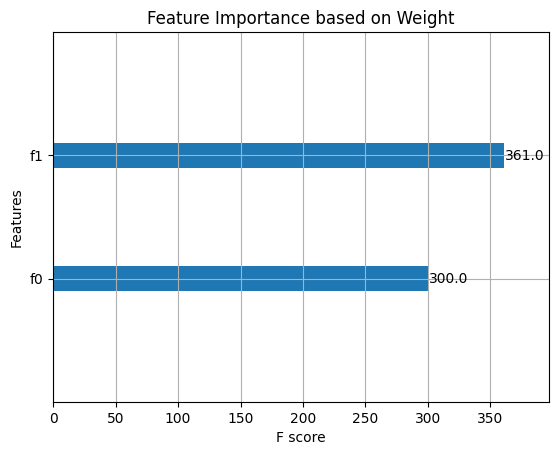

In [7]:
#p=0.1
p=0.1
random.seed(42)
real_ind=random.sample(range(len(use_index)),int(len(use_index)*p))

######
#train with real traits
X_train, X_test, y_train, y_test = train_test_split(X.iloc[real_ind], Y.iloc[real_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
def custom_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    grad = -2 * sample_weight * (y_true - y_pred)
    # Hessian (constant in this case)
    hess = 2 * sample_weight * np.ones_like(y_true)
    return grad, hess

def custom_eval_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    custom_metric_value = np.sum(sample_weight * (y_true - y_pred)**2)
    return 'CustomMetricName', custom_metric_value
params = {
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
}

# Train with custom objective
bst_real = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_real.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

######
# train with imputed traits
impute_ind=list(set(range(len(use_index)))-set(real_ind))
X_train, X_test, y_train, y_test = train_test_split(X.iloc[impute_ind], Y_impute.iloc[impute_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
bst_impute = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_impute.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

#calculate combined R^2
y_train_real=bst_real.predict(dvaltrain)
y_test_real=bst_real.predict(dvaltest)
y_train_impute=bst_impute.predict(dvaltrain)
y_test_impute=bst_impute.predict(dvaltest)

regressor_train=np.array([y_train_real,y_train_impute]).T
regressor_test=np.array([y_test_real,y_test_impute]).T
regressor_train1, regressor_val,y_train_true1, y_val_true=train_test_split(regressor_train,y_train_true,test_size=0.2,random_state=42)
#add start here
model = LinearRegression()

model.fit(regressor_train1, y_train_true1)

y_pred_comb=model.predict(regressor_test).flatten()
print('R2 of combined model:',r2_score(y_test_true,y_pred_comb))
print('R2 of single model:',r2_score(y_test_true,y_test_real))
print('R2 of single impute model:',r2_score(y_test_true,y_test_impute))
print('improvement:',(r2_score(y_test_true,y_pred_comb)-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))

residuals = np.array(y_test_true).flatten() - y_pred_comb
stderr_residuals = np.std(residuals)
X_with_const = np.column_stack([np.ones(regressor_train.shape[0]), regressor_train])
stderr_coeff = stderr_residuals * np.sqrt(np.linalg.inv(np.dot(X_with_const.T, X_with_const)).diagonal())

# Compute the t-values
t_values = model.coef_ / stderr_coeff[1:]

# Compute the p-values
p_values = (2 * (1 - stats.t.cdf(np.abs(t_values), df=len(X) - X.shape[1] - 1)))
print('pvalue:',p_values)
print('coefficients:',model.coef_)
print('intercept:',model.intercept_)
#add end here

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 0.1, 0.2],
    'objective': ['reg:squarederror']  # Objective based on the problem type
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Train the model
grid_search.fit(regressor_val, y_val_true)
best_params = grid_search.best_params_
print(best_params)
#r2_score(y_test_true,model.predict(regressor_test))

model = xgb.XGBRegressor(**best_params)
model.fit(regressor_train1,y_train_true1)
print('combined R2 with XGB:',r2_score(y_test_true,model.predict(regressor_test)))
print('improvement:',(r2_score(y_test_true,model.predict(regressor_test))-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))
# Plot feature importance based on F-score (weight)
xgb.plot_importance(model, importance_type='weight', title='Feature Importance based on Weight')
plt.show()

here


/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:48.13251	eval-CustomMetricName:2152250.50000
[1]	eval-rmse:46.32390	eval-CustomMetricName:1993545.00000
[2]	eval-rmse:44.29115	eval-CustomMetricName:1822425.12500
[3]	eval-rmse:42.65736	eval-CustomMetricName:1690455.00000
[4]	eval-rmse:41.43410	eval-CustomMetricName:1594893.00000
[5]	eval-rmse:40.31914	eval-CustomMetricName:1510213.25000
[6]	eval-rmse:39.26780	eval-CustomMetricName:1432481.25000
[7]	eval-rmse:38.49520	eval-CustomMetricName:1376667.25000
[8]	eval-rmse:37.76623	eval-CustomMetricName:1325021.37500
[9]	eval-rmse:37.27353	eval-CustomMetricName:1290674.75000
[10]	eval-rmse:36.80571	eval-CustomMetricName:1258479.25000
[11]	eval-rmse:36.41237	eval-CustomMetricName:1231724.62500
[12]	eval-rmse:36.06447	eval-CustomMetricName:1208299.75000
[13]	eval-rmse:35.84049	eval-CustomMetricName:1193338.37500
[14]	eval-rmse:35.60834	eval-CustomMetricName:1177929.37500
[15]	eval-rmse:35.41180	eval-CustomMetricName:1164962.00000
[16]	eval-rmse:35.31725	eval-CustomMetricName:1158

/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:74.11353	eval-CustomMetricName:20405810.00000
[1]	eval-rmse:73.39532	eval-CustomMetricName:20012232.00000
[2]	eval-rmse:72.70350	eval-CustomMetricName:19636744.00000
[3]	eval-rmse:72.13869	eval-CustomMetricName:19332828.00000
[4]	eval-rmse:71.65885	eval-CustomMetricName:19076488.00000
[5]	eval-rmse:71.26579	eval-CustomMetricName:18867788.00000
[6]	eval-rmse:71.01019	eval-CustomMetricName:18732688.00000
[7]	eval-rmse:70.75416	eval-CustomMetricName:18597852.00000
[8]	eval-rmse:70.54817	eval-CustomMetricName:18489720.00000
[9]	eval-rmse:70.34057	eval-CustomMetricName:18381058.00000
[10]	eval-rmse:70.22158	eval-CustomMetricName:18318924.00000
[11]	eval-rmse:70.11894	eval-CustomMetricName:18265416.00000
[12]	eval-rmse:70.06601	eval-CustomMetricName:18237850.00000
[13]	eval-rmse:70.01642	eval-CustomMetricName:18212042.00000
[14]	eval-rmse:69.95281	eval-CustomMetricName:18178968.00000
[15]	eval-rmse:69.94738	eval-CustomMetricName:18176144.00000
[16]	eval-rmse:69.91064	eval-Custo

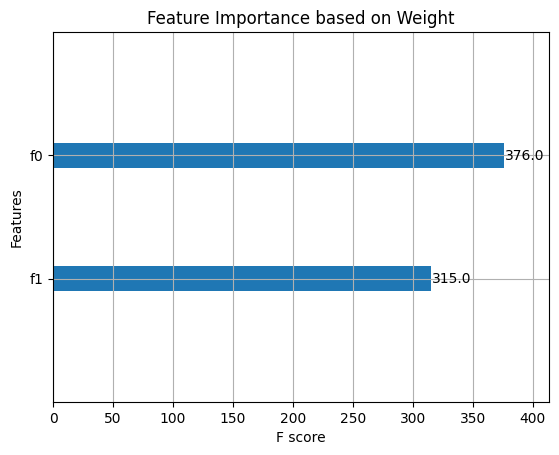

In [9]:
p=0.2
random.seed(42)
real_ind=random.sample(range(len(use_index)),int(len(use_index)*p))

######
#train with real traits
X_train, X_test, y_train, y_test = train_test_split(X.iloc[real_ind], Y.iloc[real_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
def custom_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    grad = -2 * sample_weight * (y_true - y_pred)
    # Hessian (constant in this case)
    hess = 2 * sample_weight * np.ones_like(y_true)
    return grad, hess

def custom_eval_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    custom_metric_value = np.sum(sample_weight * (y_true - y_pred)**2)
    return 'CustomMetricName', custom_metric_value
params = {
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
}

# Train with custom objective
bst_real = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_real.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

######
# train with imputed traits
impute_ind=list(set(range(len(use_index)))-set(real_ind))
X_train, X_test, y_train, y_test = train_test_split(X.iloc[impute_ind], Y_impute.iloc[impute_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
bst_impute = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_impute.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

#calculate combined R^2
y_train_real=bst_real.predict(dvaltrain)
y_test_real=bst_real.predict(dvaltest)
y_train_impute=bst_impute.predict(dvaltrain)
y_test_impute=bst_impute.predict(dvaltest)

regressor_train=np.array([y_train_real,y_train_impute]).T
regressor_test=np.array([y_test_real,y_test_impute]).T
regressor_train1, regressor_val,y_train_true1, y_val_true=train_test_split(regressor_train,y_train_true,test_size=0.2,random_state=42)
#add start here
model = LinearRegression()

model.fit(regressor_train1, y_train_true1)

y_pred_comb=model.predict(regressor_test).flatten()
print('R2 of combined model:',r2_score(y_test_true,y_pred_comb))
print('R2 of single model:',r2_score(y_test_true,y_test_real))
print('improvement:',(r2_score(y_test_true,y_pred_comb)-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))

residuals = np.array(y_test_true).flatten() - y_pred_comb
stderr_residuals = np.std(residuals)
X_with_const = np.column_stack([np.ones(regressor_train.shape[0]), regressor_train])
stderr_coeff = stderr_residuals * np.sqrt(np.linalg.inv(np.dot(X_with_const.T, X_with_const)).diagonal())

# Compute the t-values
t_values = model.coef_ / stderr_coeff[1:]

# Compute the p-values
p_values = (2 * (1 - stats.t.cdf(np.abs(t_values), df=len(X) - X.shape[1] - 1)))
print('pvalue:',p_values)
print('coefficients:',model.coef_)
print('intercept:',model.intercept_)
#add end here

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 0.1, 0.2],
    'objective': ['reg:squarederror']  # Objective based on the problem type
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Train the model
grid_search.fit(regressor_val, y_val_true)
best_params = grid_search.best_params_
print(best_params)
#r2_score(y_test_true,model.predict(regressor_test))

model = xgb.XGBRegressor(**best_params)
model.fit(regressor_train1,y_train_true1)
print('combined R2 with XGB:',r2_score(y_test_true,model.predict(regressor_test)))
print('improvement:',(r2_score(y_test_true,model.predict(regressor_test))-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))
# Plot feature importance based on F-score (weight)
xgb.plot_importance(model, importance_type='weight', title='Feature Importance based on Weight')
plt.show()

here


/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:46.77721	eval-CustomMetricName:3048034.00000
[1]	eval-rmse:44.88865	eval-CustomMetricName:2806883.00000
[2]	eval-rmse:42.85364	eval-CustomMetricName:2558153.50000
[3]	eval-rmse:41.23269	eval-CustomMetricName:2368288.25000
[4]	eval-rmse:39.70078	eval-CustomMetricName:2195579.50000
[5]	eval-rmse:38.44628	eval-CustomMetricName:2059016.62500
[6]	eval-rmse:37.41300	eval-CustomMetricName:1949827.87500
[7]	eval-rmse:36.59646	eval-CustomMetricName:1865646.50000
[8]	eval-rmse:35.94086	eval-CustomMetricName:1799400.87500
[9]	eval-rmse:35.48298	eval-CustomMetricName:1753845.25000
[10]	eval-rmse:34.97881	eval-CustomMetricName:1704359.87500
[11]	eval-rmse:34.44164	eval-CustomMetricName:1652413.25000
[12]	eval-rmse:34.13499	eval-CustomMetricName:1623120.37500
[13]	eval-rmse:33.91474	eval-CustomMetricName:1602241.62500
[14]	eval-rmse:33.58787	eval-CustomMetricName:1571506.00000
[15]	eval-rmse:33.36536	eval-CustomMetricName:1550753.75000
[16]	eval-rmse:33.19024	eval-CustomMetricName:1534

/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:74.91752	eval-CustomMetricName:18246676.00000
[1]	eval-rmse:74.11106	eval-CustomMetricName:17855952.00000
[2]	eval-rmse:73.41499	eval-CustomMetricName:17522112.00000
[3]	eval-rmse:72.83287	eval-CustomMetricName:17245340.00000
[4]	eval-rmse:72.39561	eval-CustomMetricName:17038896.00000
[5]	eval-rmse:71.99303	eval-CustomMetricName:16849924.00000
[6]	eval-rmse:71.68373	eval-CustomMetricName:16705448.00000
[7]	eval-rmse:71.36464	eval-CustomMetricName:16557056.00000
[8]	eval-rmse:71.11402	eval-CustomMetricName:16440972.00000
[9]	eval-rmse:70.94022	eval-CustomMetricName:16360708.00000
[10]	eval-rmse:70.79084	eval-CustomMetricName:16291877.00000
[11]	eval-rmse:70.70534	eval-CustomMetricName:16252545.00000
[12]	eval-rmse:70.58638	eval-CustomMetricName:16197904.00000
[13]	eval-rmse:70.43911	eval-CustomMetricName:16130385.00000
[14]	eval-rmse:70.36958	eval-CustomMetricName:16098554.00000
[15]	eval-rmse:70.31237	eval-CustomMetricName:16072390.00000
[16]	eval-rmse:70.27481	eval-Custo

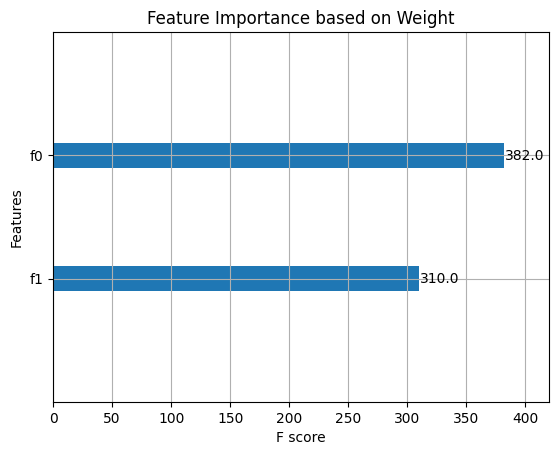

In [10]:
p=0.3
random.seed(42)
real_ind=random.sample(range(len(use_index)),int(len(use_index)*p))

######
#train with real traits
X_train, X_test, y_train, y_test = train_test_split(X.iloc[real_ind], Y.iloc[real_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
def custom_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    grad = -2 * sample_weight * (y_true - y_pred)
    # Hessian (constant in this case)
    hess = 2 * sample_weight * np.ones_like(y_true)
    return grad, hess

def custom_eval_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    custom_metric_value = np.sum(sample_weight * (y_true - y_pred)**2)
    return 'CustomMetricName', custom_metric_value
params = {
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
}

# Train with custom objective
bst_real = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_real.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

######
# train with imputed traits
impute_ind=list(set(range(len(use_index)))-set(real_ind))
X_train, X_test, y_train, y_test = train_test_split(X.iloc[impute_ind], Y_impute.iloc[impute_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
bst_impute = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_impute.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

#calculate combined R^2
y_train_real=bst_real.predict(dvaltrain)
y_test_real=bst_real.predict(dvaltest)
y_train_impute=bst_impute.predict(dvaltrain)
y_test_impute=bst_impute.predict(dvaltest)

regressor_train=np.array([y_train_real,y_train_impute]).T
regressor_test=np.array([y_test_real,y_test_impute]).T
regressor_train1, regressor_val,y_train_true1, y_val_true=train_test_split(regressor_train,y_train_true,test_size=0.2,random_state=42)
#add start here
model = LinearRegression()

model.fit(regressor_train1, y_train_true1)

y_pred_comb=model.predict(regressor_test).flatten()
print('R2 of combined model:',r2_score(y_test_true,y_pred_comb))
print('R2 of single model:',r2_score(y_test_true,y_test_real))
print('improvement:',(r2_score(y_test_true,y_pred_comb)-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))

residuals = np.array(y_test_true).flatten() - y_pred_comb
stderr_residuals = np.std(residuals)
X_with_const = np.column_stack([np.ones(regressor_train.shape[0]), regressor_train])
stderr_coeff = stderr_residuals * np.sqrt(np.linalg.inv(np.dot(X_with_const.T, X_with_const)).diagonal())

# Compute the t-values
t_values = model.coef_ / stderr_coeff[1:]

# Compute the p-values
p_values = (2 * (1 - stats.t.cdf(np.abs(t_values), df=len(X) - X.shape[1] - 1)))
print('pvalue:',p_values)
print('coefficients:',model.coef_)
print('intercept:',model.intercept_)
#add end here

param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 0.1, 0.2],
    'objective': ['reg:squarederror']  # Objective based on the problem type
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Train the model
grid_search.fit(regressor_val, y_val_true)
best_params = grid_search.best_params_
print(best_params)
#r2_score(y_test_true,model.predict(regressor_test))

model = xgb.XGBRegressor(**best_params)
model.fit(regressor_train1,y_train_true1)
print('combined R2 with XGB:',r2_score(y_test_true,model.predict(regressor_test)))
print('improvement:',(r2_score(y_test_true,model.predict(regressor_test))-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))
# Plot feature importance based on F-score (weight)
xgb.plot_importance(model, importance_type='weight', title='Feature Importance based on Weight')
plt.show()

here


/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:45.57199	eval-CustomMetricName:3858705.50000
[1]	eval-rmse:43.63905	eval-CustomMetricName:3538313.50000
[2]	eval-rmse:41.86616	eval-CustomMetricName:3256656.50000
[3]	eval-rmse:40.22458	eval-CustomMetricName:3006274.75000
[4]	eval-rmse:38.90084	eval-CustomMetricName:2811665.50000
[5]	eval-rmse:37.78911	eval-CustomMetricName:2653255.75000
[6]	eval-rmse:36.91986	eval-CustomMetricName:2532595.25000
[7]	eval-rmse:36.15965	eval-CustomMetricName:2429373.00000
[8]	eval-rmse:35.45712	eval-CustomMetricName:2335891.00000
[9]	eval-rmse:34.94399	eval-CustomMetricName:2268771.75000
[10]	eval-rmse:34.58005	eval-CustomMetricName:2221759.50000
[11]	eval-rmse:34.28776	eval-CustomMetricName:2184358.50000
[12]	eval-rmse:33.98279	eval-CustomMetricName:2145674.00000
[13]	eval-rmse:33.73910	eval-CustomMetricName:2115011.25000
[14]	eval-rmse:33.63646	eval-CustomMetricName:2102162.50000
[15]	eval-rmse:33.49040	eval-CustomMetricName:2083946.12500
[16]	eval-rmse:33.37930	eval-CustomMetricName:2070

/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:76.00109	eval-CustomMetricName:16098175.00000
[1]	eval-rmse:75.27064	eval-CustomMetricName:15790220.00000
[2]	eval-rmse:74.59800	eval-CustomMetricName:15509268.00000
[3]	eval-rmse:74.13439	eval-CustomMetricName:15317096.00000
[4]	eval-rmse:73.71673	eval-CustomMetricName:15144992.00000
[5]	eval-rmse:73.31664	eval-CustomMetricName:14981044.00000
[6]	eval-rmse:73.02572	eval-CustomMetricName:14862390.00000
[7]	eval-rmse:72.79567	eval-CustomMetricName:14768896.00000
[8]	eval-rmse:72.61899	eval-CustomMetricName:14697296.00000
[9]	eval-rmse:72.49715	eval-CustomMetricName:14648016.00000
[10]	eval-rmse:72.31980	eval-CustomMetricName:14576439.00000
[11]	eval-rmse:72.24005	eval-CustomMetricName:14544307.00000
[12]	eval-rmse:72.14425	eval-CustomMetricName:14505755.00000
[13]	eval-rmse:72.06378	eval-CustomMetricName:14473414.00000
[14]	eval-rmse:72.09690	eval-CustomMetricName:14486724.00000
[15]	eval-rmse:72.02898	eval-CustomMetricName:14459442.00000
[16]	eval-rmse:71.99976	eval-Custo

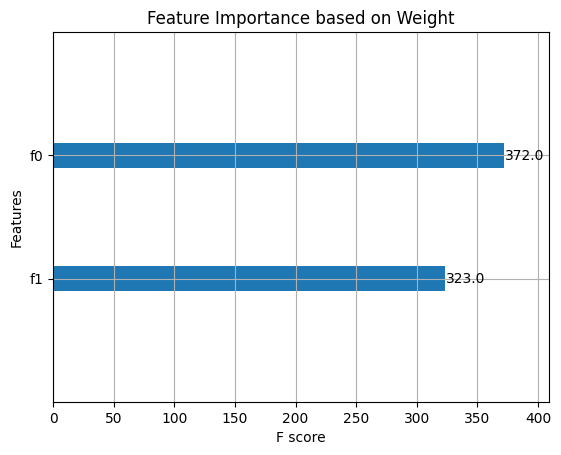

In [11]:
p=0.4
random.seed(42)
real_ind=random.sample(range(len(use_index)),int(len(use_index)*p))

######
#train with real traits
X_train, X_test, y_train, y_test = train_test_split(X.iloc[real_ind], Y.iloc[real_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
def custom_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    grad = -2 * sample_weight * (y_true - y_pred)
    # Hessian (constant in this case)
    hess = 2 * sample_weight * np.ones_like(y_true)
    return grad, hess

def custom_eval_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    custom_metric_value = np.sum(sample_weight * (y_true - y_pred)**2)
    return 'CustomMetricName', custom_metric_value
params = {
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
}

# Train with custom objective
bst_real = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_real.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

######
# train with imputed traits
impute_ind=list(set(range(len(use_index)))-set(real_ind))
X_train, X_test, y_train, y_test = train_test_split(X.iloc[impute_ind], Y_impute.iloc[impute_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
bst_impute = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_impute.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

#calculate combined R^2
y_train_real=bst_real.predict(dvaltrain)
y_test_real=bst_real.predict(dvaltest)
y_train_impute=bst_impute.predict(dvaltrain)
y_test_impute=bst_impute.predict(dvaltest)

regressor_train=np.array([y_train_real,y_train_impute]).T
regressor_test=np.array([y_test_real,y_test_impute]).T
regressor_train1, regressor_val,y_train_true1, y_val_true=train_test_split(regressor_train,y_train_true,test_size=0.2,random_state=42)

#add start here
model = LinearRegression()

model.fit(regressor_train1, y_train_true1)

y_pred_comb=model.predict(regressor_test).flatten()
print('R2 of combined model:',r2_score(y_test_true,y_pred_comb))
print('R2 of single model:',r2_score(y_test_true,y_test_real))
print('improvement:',(r2_score(y_test_true,y_pred_comb)-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))

residuals = np.array(y_test_true).flatten() - y_pred_comb
stderr_residuals = np.std(residuals)
X_with_const = np.column_stack([np.ones(regressor_train.shape[0]), regressor_train])
stderr_coeff = stderr_residuals * np.sqrt(np.linalg.inv(np.dot(X_with_const.T, X_with_const)).diagonal())

# Compute the t-values
t_values = model.coef_ / stderr_coeff[1:]

# Compute the p-values
p_values = (2 * (1 - stats.t.cdf(np.abs(t_values), df=len(X) - X.shape[1] - 1)))
print('pvalue:',p_values)
print('coefficients:',model.coef_)
print('intercept:',model.intercept_)
#add end here
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 0.1, 0.2],
    'objective': ['reg:squarederror']  # Objective based on the problem type
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Train the model
grid_search.fit(regressor_val, y_val_true)
best_params = grid_search.best_params_
print(best_params)
#r2_score(y_test_true,model.predict(regressor_test))

model = xgb.XGBRegressor(**best_params)
model.fit(regressor_train1,y_train_true1)
print('combined R2 with XGB:',r2_score(y_test_true,model.predict(regressor_test)))
print('improvement:',(r2_score(y_test_true,model.predict(regressor_test))-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))
# Plot feature importance based on F-score (weight)
xgb.plot_importance(model, importance_type='weight', title='Feature Importance based on Weight')
plt.show()

here


/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:46.76230	eval-CustomMetricName:5077547.50000
[1]	eval-rmse:44.75856	eval-CustomMetricName:4651729.00000
[2]	eval-rmse:42.80779	eval-CustomMetricName:4255082.00000
[3]	eval-rmse:41.07722	eval-CustomMetricName:3917999.25000
[4]	eval-rmse:39.68689	eval-CustomMetricName:3657264.00000
[5]	eval-rmse:38.52487	eval-CustomMetricName:3446233.25000
[6]	eval-rmse:37.51106	eval-CustomMetricName:3267238.75000
[7]	eval-rmse:36.73099	eval-CustomMetricName:3132762.00000
[8]	eval-rmse:36.05878	eval-CustomMetricName:3019146.50000
[9]	eval-rmse:35.40945	eval-CustomMetricName:2911392.00000
[10]	eval-rmse:34.91609	eval-CustomMetricName:2830827.00000
[11]	eval-rmse:34.46016	eval-CustomMetricName:2757380.50000
[12]	eval-rmse:34.09024	eval-CustomMetricName:2698500.00000
[13]	eval-rmse:33.82592	eval-CustomMetricName:2656815.00000
[14]	eval-rmse:33.59670	eval-CustomMetricName:2620930.75000
[15]	eval-rmse:33.49520	eval-CustomMetricName:2605118.00000
[16]	eval-rmse:33.36093	eval-CustomMetricName:2584

/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:74.33217	eval-CustomMetricName:12829680.00000
[1]	eval-rmse:73.61430	eval-CustomMetricName:12583070.00000
[2]	eval-rmse:72.96221	eval-CustomMetricName:12361132.00000
[3]	eval-rmse:72.41272	eval-CustomMetricName:12175646.00000
[4]	eval-rmse:71.99663	eval-CustomMetricName:12036122.00000
[5]	eval-rmse:71.57398	eval-CustomMetricName:11895220.00000
[6]	eval-rmse:71.27428	eval-CustomMetricName:11795813.00000
[7]	eval-rmse:71.01096	eval-CustomMetricName:11708816.00000
[8]	eval-rmse:70.79309	eval-CustomMetricName:11637080.00000
[9]	eval-rmse:70.65708	eval-CustomMetricName:11592407.00000
[10]	eval-rmse:70.51678	eval-CustomMetricName:11546416.00000
[11]	eval-rmse:70.43779	eval-CustomMetricName:11520562.00000
[12]	eval-rmse:70.35428	eval-CustomMetricName:11493260.00000
[13]	eval-rmse:70.26127	eval-CustomMetricName:11462892.00000
[14]	eval-rmse:70.19737	eval-CustomMetricName:11442052.00000
[15]	eval-rmse:70.14957	eval-CustomMetricName:11426472.00000
[16]	eval-rmse:70.13664	eval-Custo

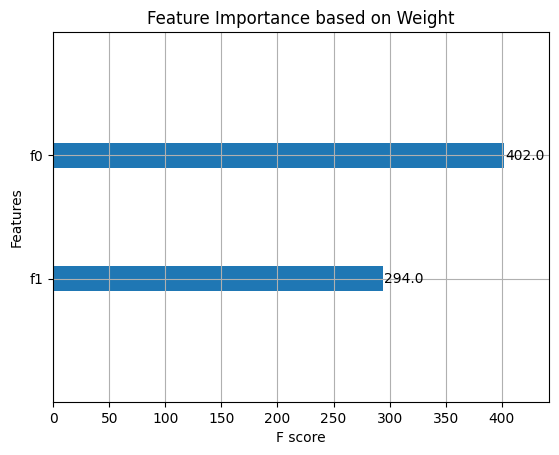

In [12]:
p=0.5
random.seed(42)
real_ind=random.sample(range(len(use_index)),int(len(use_index)*p))

######
#train with real traits
X_train, X_test, y_train, y_test = train_test_split(X.iloc[real_ind], Y.iloc[real_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
def custom_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    grad = -2 * sample_weight * (y_true - y_pred)
    # Hessian (constant in this case)
    hess = 2 * sample_weight * np.ones_like(y_true)
    return grad, hess

def custom_eval_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    custom_metric_value = np.sum(sample_weight * (y_true - y_pred)**2)
    return 'CustomMetricName', custom_metric_value
params = {
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
}

# Train with custom objective
bst_real = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_real.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

######
# train with imputed traits
impute_ind=list(set(range(len(use_index)))-set(real_ind))
X_train, X_test, y_train, y_test = train_test_split(X.iloc[impute_ind], Y_impute.iloc[impute_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
bst_impute = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_impute.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

#calculate combined R^2
y_train_real=bst_real.predict(dvaltrain)
y_test_real=bst_real.predict(dvaltest)
y_train_impute=bst_impute.predict(dvaltrain)
y_test_impute=bst_impute.predict(dvaltest)

regressor_train=np.array([y_train_real,y_train_impute]).T
regressor_test=np.array([y_test_real,y_test_impute]).T
regressor_train1, regressor_val,y_train_true1, y_val_true=train_test_split(regressor_train,y_train_true,test_size=0.2,random_state=42)

#add start here
model = LinearRegression()

model.fit(regressor_train1, y_train_true1)

y_pred_comb=model.predict(regressor_test).flatten()
print('R2 of combined model:',r2_score(y_test_true,y_pred_comb))
print('R2 of single model:',r2_score(y_test_true,y_test_real))
print('improvement:',(r2_score(y_test_true,y_pred_comb)-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))

residuals = np.array(y_test_true).flatten() - y_pred_comb
stderr_residuals = np.std(residuals)
X_with_const = np.column_stack([np.ones(regressor_train.shape[0]), regressor_train])
stderr_coeff = stderr_residuals * np.sqrt(np.linalg.inv(np.dot(X_with_const.T, X_with_const)).diagonal())

# Compute the t-values
t_values = model.coef_ / stderr_coeff[1:]

# Compute the p-values
p_values = (2 * (1 - stats.t.cdf(np.abs(t_values), df=len(X) - X.shape[1] - 1)))
print('pvalue:',p_values)
print('coefficients:',model.coef_)
print('intercept:',model.intercept_)
#add end here
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 0.1, 0.2],
    'objective': ['reg:squarederror']  # Objective based on the problem type
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Train the model
grid_search.fit(regressor_val, y_val_true)
best_params = grid_search.best_params_
print(best_params)
#r2_score(y_test_true,model.predict(regressor_test))

model = xgb.XGBRegressor(**best_params)
model.fit(regressor_train1,y_train_true1)
print('combined R2 with XGB:',r2_score(y_test_true,model.predict(regressor_test)))
print('improvement:',(r2_score(y_test_true,model.predict(regressor_test))-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))
# Plot feature importance based on F-score (weight)
xgb.plot_importance(model, importance_type='weight', title='Feature Importance based on Weight')
plt.show()

here


/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:46.89823	eval-CustomMetricName:6127652.00000
[1]	eval-rmse:44.86802	eval-CustomMetricName:5608605.00000
[2]	eval-rmse:42.84873	eval-CustomMetricName:5115134.00000
[3]	eval-rmse:41.12419	eval-CustomMetricName:4711681.00000
[4]	eval-rmse:39.70656	eval-CustomMetricName:4392438.00000
[5]	eval-rmse:38.52435	eval-CustomMetricName:4134774.00000
[6]	eval-rmse:37.51136	eval-CustomMetricName:3920187.25000
[7]	eval-rmse:36.68262	eval-CustomMetricName:3748882.00000
[8]	eval-rmse:36.01129	eval-CustomMetricName:3612920.75000
[9]	eval-rmse:35.36731	eval-CustomMetricName:3484858.00000
[10]	eval-rmse:34.89496	eval-CustomMetricName:3392396.50000
[11]	eval-rmse:34.47173	eval-CustomMetricName:3310603.25000
[12]	eval-rmse:34.08544	eval-CustomMetricName:3236823.00000
[13]	eval-rmse:33.84992	eval-CustomMetricName:3192246.25000
[14]	eval-rmse:33.63218	eval-CustomMetricName:3151309.25000
[15]	eval-rmse:33.44050	eval-CustomMetricName:3115491.25000
[16]	eval-rmse:33.30029	eval-CustomMetricName:3089

/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:75.76186	eval-CustomMetricName:10664657.00000
[1]	eval-rmse:75.12632	eval-CustomMetricName:10486484.00000
[2]	eval-rmse:74.40480	eval-CustomMetricName:10286026.00000
[3]	eval-rmse:73.84962	eval-CustomMetricName:10133096.00000
[4]	eval-rmse:73.46228	eval-CustomMetricName:10027080.00000
[5]	eval-rmse:73.19005	eval-CustomMetricName:9952904.00000
[6]	eval-rmse:72.97302	eval-CustomMetricName:9893966.00000
[7]	eval-rmse:72.81324	eval-CustomMetricName:9850685.00000
[8]	eval-rmse:72.72311	eval-CustomMetricName:9826314.00000
[9]	eval-rmse:72.58529	eval-CustomMetricName:9789104.00000
[10]	eval-rmse:72.51897	eval-CustomMetricName:9771225.00000
[11]	eval-rmse:72.50050	eval-CustomMetricName:9766246.00000
[12]	eval-rmse:72.42506	eval-CustomMetricName:9745933.00000
[13]	eval-rmse:72.26782	eval-CustomMetricName:9703660.00000
[14]	eval-rmse:72.27880	eval-CustomMetricName:9706609.00000
[15]	eval-rmse:72.31116	eval-CustomMetricName:9715302.00000
[16]	eval-rmse:72.26039	eval-CustomMetricName

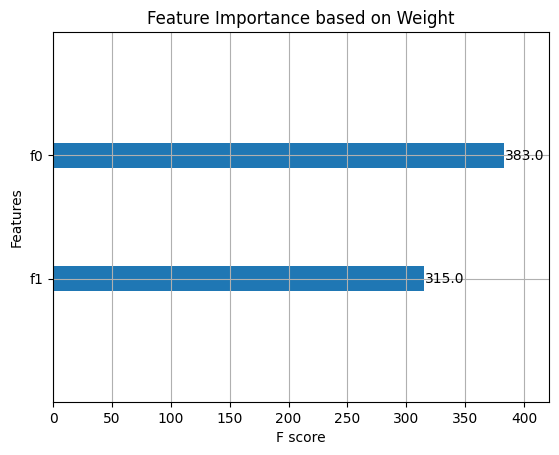

In [13]:
p=0.6
random.seed(42)
real_ind=random.sample(range(len(use_index)),int(len(use_index)*p))

######
#train with real traits
X_train, X_test, y_train, y_test = train_test_split(X.iloc[real_ind], Y.iloc[real_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
def custom_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    grad = -2 * sample_weight * (y_true - y_pred)
    # Hessian (constant in this case)
    hess = 2 * sample_weight * np.ones_like(y_true)
    return grad, hess

def custom_eval_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    custom_metric_value = np.sum(sample_weight * (y_true - y_pred)**2)
    return 'CustomMetricName', custom_metric_value
params = {
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
}

# Train with custom objective
bst_real = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_real.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

######
# train with imputed traits
impute_ind=list(set(range(len(use_index)))-set(real_ind))
X_train, X_test, y_train, y_test = train_test_split(X.iloc[impute_ind], Y_impute.iloc[impute_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
bst_impute = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_impute.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

#calculate combined R^2
y_train_real=bst_real.predict(dvaltrain)
y_test_real=bst_real.predict(dvaltest)
y_train_impute=bst_impute.predict(dvaltrain)
y_test_impute=bst_impute.predict(dvaltest)

regressor_train=np.array([y_train_real,y_train_impute]).T
regressor_test=np.array([y_test_real,y_test_impute]).T
regressor_train1, regressor_val,y_train_true1, y_val_true=train_test_split(regressor_train,y_train_true,test_size=0.2,random_state=42)

#add start here
model = LinearRegression()

model.fit(regressor_train1, y_train_true1)

y_pred_comb=model.predict(regressor_test).flatten()
print('R2 of combined model:',r2_score(y_test_true,y_pred_comb))
print('R2 of single model:',r2_score(y_test_true,y_test_real))
print('improvement:',(r2_score(y_test_true,y_pred_comb)-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))

residuals = np.array(y_test_true).flatten() - y_pred_comb
stderr_residuals = np.std(residuals)
X_with_const = np.column_stack([np.ones(regressor_train.shape[0]), regressor_train])
stderr_coeff = stderr_residuals * np.sqrt(np.linalg.inv(np.dot(X_with_const.T, X_with_const)).diagonal())

# Compute the t-values
t_values = model.coef_ / stderr_coeff[1:]

# Compute the p-values
p_values = (2 * (1 - stats.t.cdf(np.abs(t_values), df=len(X) - X.shape[1] - 1)))
print('pvalue:',p_values)
print('coefficients:',model.coef_)
print('intercept:',model.intercept_)
#add end here
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 0.1, 0.2],
    'objective': ['reg:squarederror']  # Objective based on the problem type
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Train the model
grid_search.fit(regressor_val, y_val_true)
best_params = grid_search.best_params_
print(best_params)
#r2_score(y_test_true,model.predict(regressor_test))

model = xgb.XGBRegressor(**best_params)
model.fit(regressor_train1,y_train_true1)
print('combined R2 with XGB:',r2_score(y_test_true,model.predict(regressor_test)))
print('improvement:',(r2_score(y_test_true,model.predict(regressor_test))-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))
# Plot feature importance based on F-score (weight)
xgb.plot_importance(model, importance_type='weight', title='Feature Importance based on Weight')
plt.show()

here


/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:46.98636	eval-CustomMetricName:7177290.00000
[1]	eval-rmse:44.97864	eval-CustomMetricName:6577027.00000
[2]	eval-rmse:42.95030	eval-CustomMetricName:5997212.00000
[3]	eval-rmse:41.17258	eval-CustomMetricName:5511033.00000
[4]	eval-rmse:39.70949	eval-CustomMetricName:5126318.00000
[5]	eval-rmse:38.44511	eval-CustomMetricName:4805065.00000
[6]	eval-rmse:37.35909	eval-CustomMetricName:4537425.00000
[7]	eval-rmse:36.51202	eval-CustomMetricName:4333997.00000
[8]	eval-rmse:35.73119	eval-CustomMetricName:4150610.00000
[9]	eval-rmse:35.05279	eval-CustomMetricName:3994497.50000
[10]	eval-rmse:34.53349	eval-CustomMetricName:3877018.50000
[11]	eval-rmse:34.10642	eval-CustomMetricName:3781718.00000
[12]	eval-rmse:33.77995	eval-CustomMetricName:3709667.50000
[13]	eval-rmse:33.47338	eval-CustomMetricName:3642638.25000
[14]	eval-rmse:33.21542	eval-CustomMetricName:3586710.50000
[15]	eval-rmse:33.00144	eval-CustomMetricName:3540648.50000
[16]	eval-rmse:32.80423	eval-CustomMetricName:3498

/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:73.25198	eval-CustomMetricName:7479999.00000
[1]	eval-rmse:72.38318	eval-CustomMetricName:7303619.00000
[2]	eval-rmse:71.61198	eval-CustomMetricName:7148816.00000
[3]	eval-rmse:70.88214	eval-CustomMetricName:7003844.00000
[4]	eval-rmse:70.25649	eval-CustomMetricName:6880747.50000
[5]	eval-rmse:69.87426	eval-CustomMetricName:6806082.00000
[6]	eval-rmse:69.51944	eval-CustomMetricName:6737137.00000
[7]	eval-rmse:69.19313	eval-CustomMetricName:6674039.00000
[8]	eval-rmse:69.00053	eval-CustomMetricName:6636936.00000
[9]	eval-rmse:68.76985	eval-CustomMetricName:6592633.00000
[10]	eval-rmse:68.63978	eval-CustomMetricName:6567719.00000
[11]	eval-rmse:68.66556	eval-CustomMetricName:6572652.00000
[12]	eval-rmse:68.56577	eval-CustomMetricName:6553563.50000
[13]	eval-rmse:68.43737	eval-CustomMetricName:6529040.50000
[14]	eval-rmse:68.44044	eval-CustomMetricName:6529627.00000
[15]	eval-rmse:68.39722	eval-CustomMetricName:6521383.00000
[16]	eval-rmse:68.38147	eval-CustomMetricName:6518

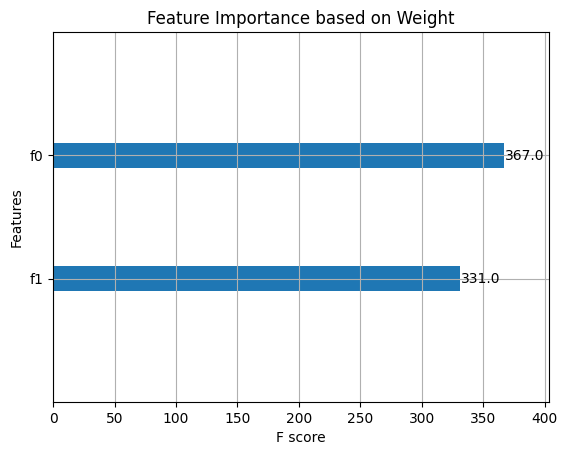

In [14]:
p=0.7
random.seed(42)
real_ind=random.sample(range(len(use_index)),int(len(use_index)*p))

######
#train with real traits
X_train, X_test, y_train, y_test = train_test_split(X.iloc[real_ind], Y.iloc[real_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
def custom_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    grad = -2 * sample_weight * (y_true - y_pred)
    # Hessian (constant in this case)
    hess = 2 * sample_weight * np.ones_like(y_true)
    return grad, hess

def custom_eval_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    custom_metric_value = np.sum(sample_weight * (y_true - y_pred)**2)
    return 'CustomMetricName', custom_metric_value
params = {
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
}

# Train with custom objective
bst_real = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_real.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

######
# train with imputed traits
impute_ind=list(set(range(len(use_index)))-set(real_ind))
X_train, X_test, y_train, y_test = train_test_split(X.iloc[impute_ind], Y_impute.iloc[impute_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
bst_impute = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_impute.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

#calculate combined R^2
y_train_real=bst_real.predict(dvaltrain)
y_test_real=bst_real.predict(dvaltest)
y_train_impute=bst_impute.predict(dvaltrain)
y_test_impute=bst_impute.predict(dvaltest)

regressor_train=np.array([y_train_real,y_train_impute]).T
regressor_test=np.array([y_test_real,y_test_impute]).T
regressor_train1, regressor_val,y_train_true1, y_val_true=train_test_split(regressor_train,y_train_true,test_size=0.2,random_state=42)

#add start here
model = LinearRegression()

model.fit(regressor_train1, y_train_true1)

y_pred_comb=model.predict(regressor_test).flatten()
print('R2 of combined model:',r2_score(y_test_true,y_pred_comb))
print('R2 of single model:',r2_score(y_test_true,y_test_real))
print('improvement:',(r2_score(y_test_true,y_pred_comb)-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))

residuals = np.array(y_test_true).flatten() - y_pred_comb
stderr_residuals = np.std(residuals)
X_with_const = np.column_stack([np.ones(regressor_train.shape[0]), regressor_train])
stderr_coeff = stderr_residuals * np.sqrt(np.linalg.inv(np.dot(X_with_const.T, X_with_const)).diagonal())

# Compute the t-values
t_values = model.coef_ / stderr_coeff[1:]

# Compute the p-values
p_values = (2 * (1 - stats.t.cdf(np.abs(t_values), df=len(X) - X.shape[1] - 1)))
print('pvalue:',p_values)
print('coefficients:',model.coef_)
print('intercept:',model.intercept_)
#add end here
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 0.1, 0.2],
    'objective': ['reg:squarederror']  # Objective based on the problem type
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Train the model
grid_search.fit(regressor_val, y_val_true)
best_params = grid_search.best_params_
print(best_params)
#r2_score(y_test_true,model.predict(regressor_test))

model = xgb.XGBRegressor(**best_params)
model.fit(regressor_train1,y_train_true1)
print('combined R2 with XGB:',r2_score(y_test_true,model.predict(regressor_test)))
print('improvement:',(r2_score(y_test_true,model.predict(regressor_test))-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))
# Plot feature importance based on F-score (weight)
xgb.plot_importance(model, importance_type='weight', title='Feature Importance based on Weight')
plt.show()

here


/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:46.78008	eval-CustomMetricName:8129816.50000
[1]	eval-rmse:44.70674	eval-CustomMetricName:7425143.00000
[2]	eval-rmse:42.69098	eval-CustomMetricName:6770661.00000
[3]	eval-rmse:40.95606	eval-CustomMetricName:6231535.50000
[4]	eval-rmse:39.49720	eval-CustomMetricName:5795507.00000
[5]	eval-rmse:38.25176	eval-CustomMetricName:5435778.00000
[6]	eval-rmse:37.15769	eval-CustomMetricName:5129277.00000
[7]	eval-rmse:36.28733	eval-CustomMetricName:4891801.00000
[8]	eval-rmse:35.56583	eval-CustomMetricName:4699207.50000
[9]	eval-rmse:34.99561	eval-CustomMetricName:4549733.00000
[10]	eval-rmse:34.48393	eval-CustomMetricName:4417660.50000
[11]	eval-rmse:34.05304	eval-CustomMetricName:4307948.50000
[12]	eval-rmse:33.73424	eval-CustomMetricName:4227667.00000
[13]	eval-rmse:33.41938	eval-CustomMetricName:4149115.75000
[14]	eval-rmse:33.11935	eval-CustomMetricName:4074951.50000
[15]	eval-rmse:32.92702	eval-CustomMetricName:4027761.00000
[16]	eval-rmse:32.69476	eval-CustomMetricName:3971

/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:72.13506	eval-CustomMetricName:4834021.00000
[1]	eval-rmse:71.37345	eval-CustomMetricName:4732483.00000
[2]	eval-rmse:70.70986	eval-CustomMetricName:4644893.00000
[3]	eval-rmse:70.26319	eval-CustomMetricName:4586394.00000
[4]	eval-rmse:69.78127	eval-CustomMetricName:4523696.00000
[5]	eval-rmse:69.29267	eval-CustomMetricName:4460569.00000
[6]	eval-rmse:69.09119	eval-CustomMetricName:4434667.00000
[7]	eval-rmse:68.91392	eval-CustomMetricName:4411940.00000
[8]	eval-rmse:68.70219	eval-CustomMetricName:4384871.50000
[9]	eval-rmse:68.68401	eval-CustomMetricName:4382551.00000
[10]	eval-rmse:68.53208	eval-CustomMetricName:4363184.00000
[11]	eval-rmse:68.33731	eval-CustomMetricName:4338418.00000
[12]	eval-rmse:68.34702	eval-CustomMetricName:4339651.50000
[13]	eval-rmse:68.24557	eval-CustomMetricName:4326778.50000
[14]	eval-rmse:68.18100	eval-CustomMetricName:4318594.00000
[15]	eval-rmse:68.17280	eval-CustomMetricName:4317556.00000
[16]	eval-rmse:68.12271	eval-CustomMetricName:4311

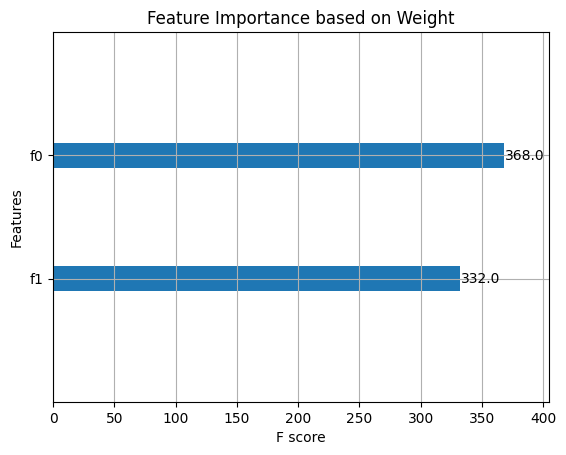

In [15]:
p=0.8
random.seed(42)
real_ind=random.sample(range(len(use_index)),int(len(use_index)*p))

######
#train with real traits
X_train, X_test, y_train, y_test = train_test_split(X.iloc[real_ind], Y.iloc[real_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
def custom_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    grad = -2 * sample_weight * (y_true - y_pred)
    # Hessian (constant in this case)
    hess = 2 * sample_weight * np.ones_like(y_true)
    return grad, hess

def custom_eval_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    custom_metric_value = np.sum(sample_weight * (y_true - y_pred)**2)
    return 'CustomMetricName', custom_metric_value
params = {
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
}

# Train with custom objective
bst_real = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_real.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

######
# train with imputed traits
impute_ind=list(set(range(len(use_index)))-set(real_ind))
X_train, X_test, y_train, y_test = train_test_split(X.iloc[impute_ind], Y_impute.iloc[impute_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
bst_impute = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_impute.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

#calculate combined R^2
y_train_real=bst_real.predict(dvaltrain)
y_test_real=bst_real.predict(dvaltest)
y_train_impute=bst_impute.predict(dvaltrain)
y_test_impute=bst_impute.predict(dvaltest)

regressor_train=np.array([y_train_real,y_train_impute]).T
regressor_test=np.array([y_test_real,y_test_impute]).T
regressor_train1, regressor_val,y_train_true1, y_val_true=train_test_split(regressor_train,y_train_true,test_size=0.2,random_state=42)

#add start here
model = LinearRegression()

model.fit(regressor_train1, y_train_true1)

y_pred_comb=model.predict(regressor_test).flatten()
print('R2 of combined model:',r2_score(y_test_true,y_pred_comb))
print('R2 of single model:',r2_score(y_test_true,y_test_real))
print('improvement:',(r2_score(y_test_true,y_pred_comb)-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))

residuals = np.array(y_test_true).flatten() - y_pred_comb
stderr_residuals = np.std(residuals)
X_with_const = np.column_stack([np.ones(regressor_train.shape[0]), regressor_train])
stderr_coeff = stderr_residuals * np.sqrt(np.linalg.inv(np.dot(X_with_const.T, X_with_const)).diagonal())

# Compute the t-values
t_values = model.coef_ / stderr_coeff[1:]

# Compute the p-values
p_values = (2 * (1 - stats.t.cdf(np.abs(t_values), df=len(X) - X.shape[1] - 1)))
print('pvalue:',p_values)
print('coefficients:',model.coef_)
print('intercept:',model.intercept_)
#add end here
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 0.1, 0.2],
    'objective': ['reg:squarederror']  # Objective based on the problem type
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Train the model
grid_search.fit(regressor_val, y_val_true)
best_params = grid_search.best_params_
print(best_params)
#r2_score(y_test_true,model.predict(regressor_test))

model = xgb.XGBRegressor(**best_params)
model.fit(regressor_train1,y_train_true1)
print('combined R2 with XGB:',r2_score(y_test_true,model.predict(regressor_test)))
print('improvement:',(r2_score(y_test_true,model.predict(regressor_test))-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))
# Plot feature importance based on F-score (weight)
xgb.plot_importance(model, importance_type='weight', title='Feature Importance based on Weight')
plt.show()

here


/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:47.28094	eval-CustomMetricName:9342102.00000
[1]	eval-rmse:45.23600	eval-CustomMetricName:8551471.00000
[2]	eval-rmse:43.24508	eval-CustomMetricName:7815301.00000
[3]	eval-rmse:41.56327	eval-CustomMetricName:7219245.00000
[4]	eval-rmse:40.12757	eval-CustomMetricName:6729116.00000
[5]	eval-rmse:38.87439	eval-CustomMetricName:6315381.00000
[6]	eval-rmse:37.84771	eval-CustomMetricName:5986205.50000
[7]	eval-rmse:36.97805	eval-CustomMetricName:5714265.50000
[8]	eval-rmse:36.22176	eval-CustomMetricName:5482915.00000
[9]	eval-rmse:35.63562	eval-CustomMetricName:5306901.00000
[10]	eval-rmse:35.11525	eval-CustomMetricName:5153043.50000
[11]	eval-rmse:34.64172	eval-CustomMetricName:5015003.00000
[12]	eval-rmse:34.23944	eval-CustomMetricName:4899207.00000
[13]	eval-rmse:33.92160	eval-CustomMetricName:4808671.00000
[14]	eval-rmse:33.65678	eval-CustomMetricName:4733882.50000
[15]	eval-rmse:33.39501	eval-CustomMetricName:4660531.00000
[16]	eval-rmse:33.18600	eval-CustomMetricName:4602

/home/panwei/fu000217/.local/lib/python3.8/site-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


[0]	eval-rmse:79.61157	eval-CustomMetricName:2947171.00000
[1]	eval-rmse:78.78679	eval-CustomMetricName:2886421.50000
[2]	eval-rmse:78.04521	eval-CustomMetricName:2832340.25000
[3]	eval-rmse:77.61891	eval-CustomMetricName:2801483.00000
[4]	eval-rmse:76.92707	eval-CustomMetricName:2751765.00000
[5]	eval-rmse:76.61015	eval-CustomMetricName:2729138.25000
[6]	eval-rmse:76.24005	eval-CustomMetricName:2702833.50000
[7]	eval-rmse:75.76028	eval-CustomMetricName:2668923.25000
[8]	eval-rmse:75.56729	eval-CustomMetricName:2655343.00000
[9]	eval-rmse:75.60566	eval-CustomMetricName:2658040.50000
[10]	eval-rmse:75.22623	eval-CustomMetricName:2631428.50000
[11]	eval-rmse:74.95958	eval-CustomMetricName:2612806.00000
[12]	eval-rmse:74.78827	eval-CustomMetricName:2600877.50000
[13]	eval-rmse:74.86494	eval-CustomMetricName:2606212.75000
[14]	eval-rmse:74.67908	eval-CustomMetricName:2593289.00000
[15]	eval-rmse:74.60151	eval-CustomMetricName:2587904.50000
[16]	eval-rmse:74.55519	eval-CustomMetricName:2584

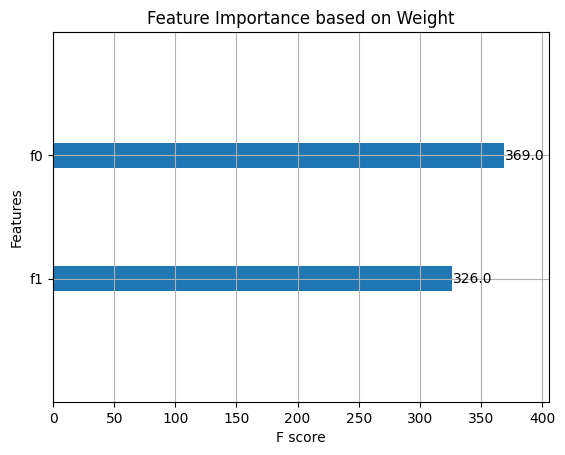

In [16]:
p=0.9
random.seed(42)
real_ind=random.sample(range(len(use_index)),int(len(use_index)*p))

######
#train with real traits
X_train, X_test, y_train, y_test = train_test_split(X.iloc[real_ind], Y.iloc[real_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
def custom_loss(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    grad = -2 * sample_weight * (y_true - y_pred)
    # Hessian (constant in this case)
    hess = 2 * sample_weight * np.ones_like(y_true)
    return grad, hess

def custom_eval_metric(y_pred, dtrain):
    y_true = dtrain.get_label()
    sample_weight = dtrain.get_weight()
    # Gradient
    custom_metric_value = np.sum(sample_weight * (y_true - y_pred)**2)
    return 'CustomMetricName', custom_metric_value
params = {
    'eta': 0.1,
    'max_depth': 6,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
}

# Train with custom objective
bst_real = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_real.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

######
# train with imputed traits
impute_ind=list(set(range(len(use_index)))-set(real_ind))
X_train, X_test, y_train, y_test = train_test_split(X.iloc[impute_ind], Y_impute.iloc[impute_ind], test_size=0.2, random_state=42)
sample_weights_train=np.ones(X_train.shape[0])
sample_weights_test=np.ones(X_test.shape[0])
dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights_train)
dtest = xgb.DMatrix(X_test, label=y_test, weight=sample_weights_test)
print('here')
bst_impute = xgb.train(params, dtrain, num_boost_round=1000, early_stopping_rounds=20, 
                evals=[(dtest, 'eval')], obj=custom_loss, feval=custom_eval_metric)
#bst.save_model('/home/panwei/fu000217/dl/LipA/7_apply/xgb/real/full_real.model')
y_pred = bst_impute.predict(dvaltest)
print(r2_score(dvaltest.get_label(),y_pred))
del dtrain
del dtest, X_train, X_test, y_train, y_test
gc.collect()

#calculate combined R^2
y_train_real=bst_real.predict(dvaltrain)
y_test_real=bst_real.predict(dvaltest)
y_train_impute=bst_impute.predict(dvaltrain)
y_test_impute=bst_impute.predict(dvaltest)

regressor_train=np.array([y_train_real,y_train_impute]).T
regressor_test=np.array([y_test_real,y_test_impute]).T
regressor_train1, regressor_val,y_train_true1, y_val_true=train_test_split(regressor_train,y_train_true,test_size=0.2,random_state=42)

#add start here
model = LinearRegression()

model.fit(regressor_train1, y_train_true1)

y_pred_comb=model.predict(regressor_test).flatten()
print('R2 of combined model:',r2_score(y_test_true,y_pred_comb))
print('R2 of single model:',r2_score(y_test_true,y_test_real))
print('improvement:',(r2_score(y_test_true,y_pred_comb)-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))

residuals = np.array(y_test_true).flatten() - y_pred_comb
stderr_residuals = np.std(residuals)
X_with_const = np.column_stack([np.ones(regressor_train.shape[0]), regressor_train])
stderr_coeff = stderr_residuals * np.sqrt(np.linalg.inv(np.dot(X_with_const.T, X_with_const)).diagonal())

# Compute the t-values
t_values = model.coef_ / stderr_coeff[1:]

# Compute the p-values
p_values = (2 * (1 - stats.t.cdf(np.abs(t_values), df=len(X) - X.shape[1] - 1)))
print('pvalue:',p_values)
print('coefficients:',model.coef_)
print('intercept:',model.intercept_)
#add end here
param_grid = {
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.5, 0.7, 1],
    'colsample_bytree': [0.5, 0.7, 1],
    'gamma': [0, 0.1, 0.2],
    'objective': ['reg:squarederror']  # Objective based on the problem type
}

model = xgb.XGBRegressor()
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)

# Train the model
grid_search.fit(regressor_val, y_val_true)
best_params = grid_search.best_params_
print(best_params)
#r2_score(y_test_true,model.predict(regressor_test))

model = xgb.XGBRegressor(**best_params)
model.fit(regressor_train1,y_train_true1)
print('combined R2 with XGB:',r2_score(y_test_true,model.predict(regressor_test)))
print('improvement:',(r2_score(y_test_true,model.predict(regressor_test))-r2_score(y_test_true,y_test_real))/r2_score(y_test_true,y_test_real))
# Plot feature importance based on F-score (weight)
xgb.plot_importance(model, importance_type='weight', title='Feature Importance based on Weight')
plt.show()